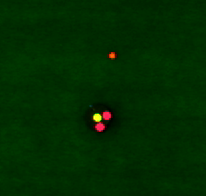

Robot Centers: []
Ball Centers: []


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def classifyImage(image, thresholds):
    colors = ["Yellow", "Orange", "Pink", "Green", "Blue"]
    classified_image = np.zeros_like(image)

    for i, threshold in enumerate(thresholds):
        lower = np.array(threshold[:3], dtype=np.uint8)
        upper = np.array(threshold[3:], dtype=np.uint8)
        mask = cv2.inRange(image, lower, upper)
        classified_image[mask != 0] = i + 1  # Using color ID as the assigned value
    return classified_image

def sslDetect(image_file, threshold_file):
    image = cv2.imread(image_file)
    thresholds = np.loadtxt(threshold_file, delimiter=",", dtype=np.uint8)

    classified_image = classifyImage(image, thresholds)
    gray_image = cv2.cvtColor(classified_image, cv2.COLOR_BGR2GRAY)

    # Classify robots and balls
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    robot_centers = []
    ball_centers = []

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        center = (int(x + w/2), int(y + h/2))

        if w > h:
            robot_centers.append(center)
        else:
            ball_centers.append(center)

        # Calculate rectangle coordinates
        rect_width = 20
        rect_height = 20
        x_min = x - rect_width // 2
        y_min = y - rect_height // 2
        x_max = x + rect_width // 2
        y_max = y + rect_height // 2

        # Draw rectangle around the object
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return robot_centers, ball_centers

# Example usage of sslDetect function with the provided image and thresholds
image_file = "/content/sample1.bmp"
threshold_file = "/content/sample1.txt"

robot_centers, ball_centers = sslDetect(image_file, threshold_file)

print("Robot Centers:", robot_centers)
print("Ball Centers:", ball_centers)


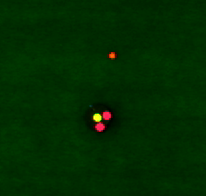

Robot Centers: []
Ball Centers: []
Robot Bounding Boxes: []
Ball Bounding Boxes: []


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def classifyPixel(pixel, thresholds):
    colors = ["Yellow", "Orange", "Pink", "Green", "Blue"]
    for i, threshold in enumerate(thresholds):
        r_min, r_max, g_min, g_max, b_min, b_max = threshold
        if (pixel[2] >= r_min) and (pixel[2] <= r_max) and (pixel[1] >= g_min) and (pixel[1] <= g_max) and (pixel[0] >= b_min) and (pixel[0] <= b_max):
            return colors[i]
    return "Unknown"


def findOuterEdges(image_file, thresholds):
    image = cv2.imread(image_file)
    height, width, _ = image.shape
    outer_edges = []

    # Start from the top-left corner
    start_pixel = (0, 0)
    color = classifyPixel(image[start_pixel[1], start_pixel[0]], thresholds)
    while color == "Unknown" and start_pixel[1] < height - 1:
        start_pixel = (start_pixel[0], start_pixel[1] + 1)
        color = classifyPixel(image[start_pixel[1], start_pixel[0]], thresholds)

    if color != "Unknown":
        outer_edges.append(start_pixel)

    # Traverse around the image
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]  # Directions for traversal
    direction_index = 0  # Current direction index
    current_pixel = start_pixel
    while True:
        next_pixel = (current_pixel[0] + directions[direction_index][0], current_pixel[1] + directions[direction_index][1])
        if next_pixel in outer_edges:
            break

        if next_pixel[0] >= 0 and next_pixel[0] < width and next_pixel[1] >= 0 and next_pixel[1] < height:
            color = classifyPixel(image[next_pixel[1], next_pixel[0]], thresholds)
            if color != "Unknown":
                outer_edges.append(next_pixel)
                current_pixel = next_pixel
                direction_index = (direction_index + 1) % 4
            else:
                direction_index = (direction_index - 1) % 4
        else:
            direction_index = (direction_index - 1) % 4

    return outer_edges


def expandBoundingBox(image, start_pixel, color):
    height, width, _ = image.shape
    bounding_box = [start_pixel[0], start_pixel[0], start_pixel[1], start_pixel[1]]  # [x_min, x_max, y_min, y_max]

    stack = [start_pixel]
    while stack:
        pixel = stack.pop()
        bounding_box[0] = min(bounding_box[0], pixel[0])
        bounding_box[1] = max(bounding_box[1], pixel[0])
        bounding_box[2] = min(bounding_box[2], pixel[1])
        bounding_box[3] = max(bounding_box[3], pixel[1])

        for dy in range(-1, 2):
            for dx in range(-1, 2):
                next_pixel = (pixel[0] + dx, pixel[1] + dy)
                if next_pixel[0] >= 0 and next_pixel[0] < width and next_pixel[1] >= 0 and next_pixel[1] < height:
                    if classifyPixel(image[next_pixel[1], next_pixel[0]], thresholds) == color and next_pixel not in stack:
                        stack.append(next_pixel)

    return bounding_box


def calculateBoundingBoxSize(bounding_box):
    width = bounding_box[1] - bounding_box[0] + 1
    height = bounding_box[3] - bounding_box[2] + 1
    size = width * height
    return size


def sslDetect(image_file, threshold_file):
    image = cv2.imread(image_file)
    thresholds = np.loadtxt(threshold_file, delimiter=",", dtype=np.uint8)

    height, width, _ = image.shape
    classified_image = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            pixel = image[i, j]
            color = classifyPixel(pixel, thresholds)
            if color != "Unknown":
                classified_image[i, j] = [255, 255, 255] if color == "White" else [0, 0, 0]

    gray_image = cv2.cvtColor(classified_image, cv2.COLOR_BGR2GRAY)

    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    robot_centers = []
    ball_centers = []
    robot_bounding_boxes = []
    ball_bounding_boxes = []

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        center = (int(x + w/2), int(y + h/2))

        if w > h:
            robot_centers.append(center)
            robot_bounding_boxes.append((x, y, x + w - 1, y + h - 1))
        else:
            ball_centers.append(center)
            ball_bounding_boxes.append((x, y, x + w - 1, y + h - 1))

        x_min = x - 5
        y_min = y - 5
        x_max = x + 5
        y_max = y + 5
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return robot_centers, ball_centers, robot_bounding_boxes, ball_bounding_boxes


# Example usage of sslDetect function with the provided image and thresholds
image_file = "/content/sample1.bmp"
threshold_file = "/content/sample1.txt"

robot_centers, ball_centers, robot_bounding_boxes, ball_bounding_boxes = sslDetect(image_file, threshold_file)

print("Robot Centers:", robot_centers)
print("Ball Centers:", ball_centers)
print("Robot Bounding Boxes:", robot_bounding_boxes)
print("Ball Bounding Boxes:", ball_bounding_boxes)


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def classifyImage(image_file, threshold_file):
    # Load the image
    image = cv2.imread(image_file)
    height, width, _ = image.shape

    # Initialize the classified image with black pixels
    classified_image = np.zeros((height, width, 3), np.uint8)

    # Load the threshold values
    with open(threshold_file, 'r') as file:
        thresholds = file.readlines()

    # Process each pixel in the image
    for y in range(height):
        for x in range(width):
            pixel = image[y, x]

            # Classify the pixel based on color thresholds
            color_class = classifyPixel(pixel, thresholds)

            # Color the pixel based on its class
            classified_image[y, x] = getColor(color_class)

    # Show the classified image
    cv2_imshow(classified_image)

def classifyPixel(pixel, thresholds):
    # Parse the threshold values
    colors = ['Yellow', 'Orange', 'Pink', 'Green', 'Blue']
    thresholds = [list(map(int, threshold.strip().split(','))) for threshold in thresholds]

    # Check if the pixel belongs to any color group
    for i, color in enumerate(colors):
        r_min, r_max, g_min, g_max, b_min, b_max = thresholds[i]
        r, g, b = pixel

        if r_min <= r <= r_max and g_min <= g <= g_max and b_min <= b <= b_max:
            return color

    # Pixel doesn't belong to any color group
    return 'Black'

def getColor(color_class):
    colors = {
        'Yellow': (0, 255, 255),
        'Orange': (0, 140, 255),
        'Pink': (203, 192, 255),
        'Green': (0, 255, 0),
        'Blue': (255, 0, 0),
        'Black': (0, 0, 0)
    }

    return colors[color_class]

# Example usage
classifyImage("/content/sample1.bmp", "/content/sample1.txt")


IndexError: ignored

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def classifyPixel(pixel, thresholds, colors):
    # Extract the RGB values of the pixel
    r, g, b = pixel

    # Check if the pixel belongs to any color class
    for i, color in enumerate(colors):
        r_min, r_max, g_min, g_max, b_min, b_max = thresholds[i]

        if (r_min <= r <= r_max) and (g_min <= g <= g_max) and (b_min <= b <= b_max):
            return color
        print(color)

    # If the pixel does not belong to any color class, return None
    return None

def classifyImage(image_path, thresholds_path):
    # Read the image
    image = cv2.imread(image_path)

    # Read the thresholds
    with open(thresholds_path, 'r') as file:
        lines = file.readlines()

    thresholds = []
    colors = []

    # Extract the thresholds and colors from each line
    for line in lines:
        values = line.strip().split(',')
        r_min, r_max, g_min, g_max, b_min, b_max = map(int, values)
        thresholds.append((r_min, r_max, g_min, g_max, b_min, b_max))

        # Determine the color based on the index
        if len(colors) == 0:
            color = 'Yellow'
        elif len(colors) == 1:
            color = 'Orange'
        elif len(colors) == 2:
            color = 'Pink'
        elif len(colors) == 3:
            color = 'Green'
        else:
            color = 'Blue'

        colors.append(color)

    # Create an empty image for visualization
    output_image = np.zeros_like(image)

    # Create empty lists to store the robot and ball coordinates
    robot_coordinates = []
    ball_coordinates = []

    # Classify each pixel and update the output image and coordinates
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = image[i, j]
            color = classifyPixel(pixel, thresholds, colors)

            if color is not None:
                # Update the output image with the color rectangle
                cv2.rectangle(output_image, (j-1, i-1), (j+1, i+1), color=color, thickness=2)

                # Update the coordinates based on the color
                if color == 'Yellow':
                    robot_coordinates.append((i, j))
                elif color == 'Orange':
                    ball_coordinates.append((i, j))

    # Display the output image
    cv2_imshow(output_image)
    print(color)
    # Return the robot and ball coordinates
    return robot_coordinates, ball_coordinates

# Example usage
classifyImage("/content/sample1.bmp", "/content/sample1.txt")


Streaming output truncated to the last 5000 lines.
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow
Orange
Pink
Green
Yellow

KeyboardInterrupt: ignored

In [ ]:
thresholds

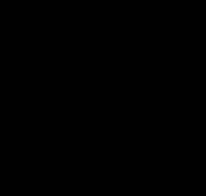

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def classifyImage(image_file, threshold_file):
    # Load the image
    image = cv2.imread(image_file)
    height, width, _ = image.shape

    # Initialize the classified image with black pixels
    classified_image = np.zeros((height, width, 3), np.uint8)

    # Read the thresholds
    with open(threshold_file, 'r') as file:
        lines = file.readlines()

    thresholds = []
    colors = []

    # Extract the thresholds and colors from each line
    for line in lines:
        values = line.strip().split(',')
        r_min, r_max, g_min, g_max, b_min, b_max = map(int, values)
        thresholds.append((r_min, r_max, g_min, g_max, b_min, b_max))

    # Process each pixel in the image
    for y in range(height):
        for x in range(width):
            pixel = image[y, x]

            # Classify the pixel based on color thresholds
            color_class = classifyPixel(pixel, thresholds)

            # Color the pixel based on its class
            classified_image[y, x] = getColor(color_class)

    # Show the classified image
    cv2_imshow(classified_image)

def classifyPixel(pixel, thresholds):
    # Parse the threshold values
    colors = ['Yellow', 'Orange', 'Pink', 'Green', 'Blue']

    # Check if the pixel belongs to any color group
    for i, color in enumerate(colors):
        if i < len(thresholds):
            r_min, r_max, g_min, g_max, b_min, b_max = thresholds[i]
            r, g, b = pixel

            if r_min <= r <= r_max and g_min <= g <= g_max and b_min <= b <= b_max:
                return color

    # Pixel doesn't belong to any color group
    return 'Black'

def getColor(color_class):
    colors = {
        'Yellow': (0, 255, 255),
        'Orange': (0, 140, 255),
        'Pink': (203, 192, 255),
        'Green': (0, 255, 0),
        'Blue': (255, 0, 0),
        'Black': (0, 0, 0)
    }

    return colors[color_class]

# Example usage
classifyImage("/content/sample1.bmp", "/content/sample1.txt")


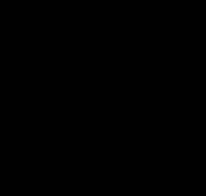

([], [])

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def classifyPixel(pixel, thresholds, colors):
    # Extract the RGB values of the pixel
    r, g, b = pixel

    # Check if the pixel belongs to any color class
    for i, color in enumerate(colors):
        r_min, r_max, g_min, g_max, b_min, b_max = thresholds[i]

        if (r_min <= r <= r_max) and (g_min <= g <= g_max) and (b_min <= b <= b_max):
            return color

    # If the pixel does not belong to any color class, return None
    return None

def classifyImage(image_path, thresholds_path):
    # Read the image
    image = cv2.imread(image_path)

    # Read the thresholds
    with open(thresholds_path, 'r') as file:
        lines = file.readlines()

    thresholds = []
    colors = []

    # Extract the thresholds and colors from each line
    for line in lines:
        values = line.strip().split(',')
        r_min, r_max, g_min, g_max, b_min, b_max = map(int, values)
        thresholds.append((r_min, r_max, g_min, g_max, b_min, b_max))

        # Determine the color based on the index
        if len(colors) == 0:
            color = 'Yellow'
        elif len(colors) == 1:
            color = 'Orange'
        elif len(colors) == 2:
            color = 'Pink'
        elif len(colors) == 3:
            color = 'Green'
        else:
            color = 'Blue'

        colors.append(color)

    # Create an empty image for visualization
    output_image = np.zeros_like(image)

    # Create empty lists to store the robot and ball coordinates
    robot_coordinates = []
    ball_coordinates = []

    # Classify each pixel and update the output image and coordinates
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = image[i, j]
            color = classifyPixel(pixel, thresholds, colors)

            # Color the pixel based on its class
            classified_image[y, x] = getColor(color_class)

            if color is not None:
                # Update the output image with the color rectangle
                cv2.rectangle(output_image, (j-1, i-1), (j+1, i+1), color=getColor(color), thickness=2)

                # Update the coordinates based on the color
                if color == 'Yellow':
                    robot_coordinates.append((i, j))
                elif color == 'Orange':
                    ball_coordinates.append((i, j))

    # Display the output image
    cv2_imshow(output_image)

    # Return the robot and ball coordinates
    return robot_coordinates, ball_coordinates

def getColor(color_class):
    colors = {
        'Yellow': (0, 255, 255),
        'Orange': (0, 140, 255),
        'Pink': (203, 192, 255),
        'Green': (0, 255, 0),
        'Blue': (255, 0, 0),
        'Black': (0, 0, 0)
    }

    return colors[color_class]

# Example usage
classifyImage("/content/sample1.bmp", "/content/sample1.txt")


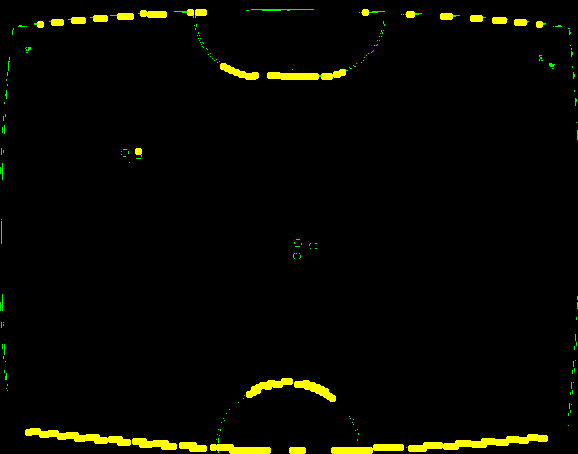

Robot Centers: [(190, 12), (198, 12), (199, 12), (200, 12), (201, 12), (202, 12), (203, 12), (365, 12), (143, 13), (150, 14), (152, 14), (153, 14), (154, 14), (155, 14), (156, 14), (157, 14), (158, 14), (159, 14), (160, 14), (161, 14), (162, 14), (163, 14), (409, 14), (411, 14), (120, 16), (121, 16), (122, 16), (123, 16), (124, 16), (125, 16), (126, 16), (127, 16), (128, 16), (129, 16), (130, 16), (443, 16), (444, 16), (445, 16), (447, 16), (449, 16), (96, 18), (98, 18), (99, 18), (100, 18), (101, 18), (102, 18), (103, 18), (104, 18), (473, 18), (474, 18), (475, 18), (476, 18), (477, 18), (479, 18), (74, 20), (75, 20), (76, 20), (77, 20), (78, 20), (79, 20), (80, 20), (81, 20), (82, 20), (495, 20), (496, 20), (497, 20), (498, 20), (499, 20), (501, 20), (503, 20), (54, 22), (56, 22), (58, 22), (59, 22), (60, 22), (517, 22), (519, 22), (521, 22), (523, 22), (40, 24), (539, 24), (223, 66), (227, 68), (231, 70), (236, 72), (342, 72), (241, 74), (242, 74), (336, 74), (337, 74), (254, 75), (

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def classifyPixel(pixel, thresholds):
    # Parse the threshold values
    colors = ['Yellow', 'Orange', 'Pink', 'Green', 'Blue']

    # Check if the pixel belongs to any color group
    for i, color in enumerate(colors):
        if i < len(thresholds):
            r_min, r_max, g_min, g_max, b_min, b_max = thresholds[i]
            r, g, b = pixel

            if r_min <= r <= r_max and g_min <= g <= g_max and b_min <= b <= b_max:
                return color

    # Pixel doesn't belong to any color group
    return 'Black'

def getColor(color_class):
    colors = {
        'Yellow': (0, 255, 255),
        'Orange': (0, 140, 255),
        'Pink': (203, 192, 255),
        'Green': (0, 255, 0),
        'Blue': (255, 0, 0),
        'Black': (0, 0, 0)
    }

    return colors[color_class]

def classifyImage(image_file, threshold_file):
    # Load the image
    image = cv2.imread(image_file)
    height, width, _ = image.shape

    # Initialize the classified image with black pixels
    classified_image = np.zeros((height, width, 3), np.uint8)

    # Read the thresholds
    with open(threshold_file, 'r') as file:
        lines = file.readlines()

    thresholds = []

    # Extract the thresholds from each line
    for line in lines:
        values = line.strip().split(',')
        r_min, r_max, g_min, g_max, b_min, b_max = map(int, values)
        thresholds.append((r_min, r_max, g_min, g_max, b_min, b_max))

    # Create empty lists to store the robot and ball coordinates
    robot_coordinates = []
    ball_coordinates = []

    # Process each pixel in the image
    for y in range(height):
        for x in range(width):
            pixel = image[y, x]

            # Classify the pixel based on color thresholds
            color_class = classifyPixel(pixel, thresholds)

            # Color the pixel based on its class
            classified_image[y, x] = getColor(color_class)

            # Update the coordinates based on the color
            if color_class == 'Yellow':
                robot_coordinates.append((x, y))
            elif color_class == 'Orange':
                ball_coordinates.append((x, y))
            #print(color_class)

    # Draw rectangles around the robots and balls in the output image
    for x, y in robot_coordinates:
        cv2.rectangle(classified_image, (x-2, y-2), (x+2, y+2), (0, 255, 255), thickness=2)

    for x, y in ball_coordinates:
        cv2.rectangle(classified_image, (x-2, y-2), (x+2, y+2), (0, 140, 255), thickness=2)

    # Show the classified image
    cv2_imshow(classified_image)

    # Return the robot and ball coordinates
    return robot_coordinates, ball_coordinates

# Example usage
robot_centers, ball_centers =classifyImage("/content/sample2.bmp", "/content/sample2.txt")


print("Robot Centers:", robot_centers)
print("Ball Centers:", ball_centers)
